In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

import unicodedata
import re
import numpy as np
import os
import io
import time
import tensorflow_text as tf_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
europarl_lines = pd.read_csv('/kaggle/input/nmt-capstone/europarl-v7.csv')
europarl_lines_bp = europarl_lines.copy()
europarl_lines = europarl_lines[:25000]
europarl_lines.reset_index(drop=True, inplace=True)
europarl_lines.head()

,index,German_Text,English_Text,all_text
0,0,Wiederaufnahme der Sitzungsperiode,Resumption of the session,Resumption of the session;Wiederaufnahme der S...
1,1,"Ich erkläre die am Freitag, dem 17. Dezember u...",I declare resumed the session of the European ...,I declare resumed the session of the European ...
2,2,"Wie Sie feststellen konnten, ist der gefürchte...","Although, as you will have seen, the dreaded '...","Although, as you will have seen, the dreaded '..."
3,3,Im Parlament besteht der Wunsch nach einer Aus...,You have requested a debate on this subject in...,You have requested a debate on this subject in...
4,4,Heute möchte ich Sie bitten - das ist auch der...,"In the meantime, I should like to observe a mi...","In the meantime, I should like to observe a mi..."


In [3]:
target_raw = np.array(list(europarl_lines['German_Text'].values))
context_raw = np.array(list(europarl_lines['English_Text'].values))
print(context_raw[-1])

Mr President, the European Union, which advocates and practises a set of values which we are proud to say is at the forefront of the international community, has been emphasising the vital importance of observing the Geneva Conventions.


In [4]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [5]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [6]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [7]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', ',', '.', '[START]', '[END]', 'of', 'to', 'and']

In [8]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', 'die', '.', '[START]', '[END]', 'der', 'und', 'in']

In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
#   print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break


tf.Tensor(
[b'Pr\xc3\xa4sident Wahid ben\xc3\xb6tigt unsere Unterst\xc3\xbctzung, um die schwierige Situation zu bew\xc3\xa4ltigen, vor der er steht.'
 b'Ein Ziel dieses Programms ist die Erarbeitung und Kontrolle von Methoden, Strategien und Ma\xc3\x9fnahmen zur F\xc3\xb6rderung einer gleichm\xc3\xa4\xc3\x9figen Verteilung der Geschlechter bei den Entscheidungsprozessen, u. a. in verantwortlichen Positionen.'
 b'Wir schlagen vor, diese Bestimmungen um die Festlegung von Rechten und Pflichten f\xc3\xbcr Beamte zu erg\xc3\xa4nzen, denen zufolge sie vermutetes Fehlverhalten \xc3\xbcber interne Kan\xc3\xa4le, jedoch nicht ausschlie\xc3\x9flich auf der gleichen Hierarchieebene anzeigen m\xc3\xbcssen.'
 b'In dieser Hinsicht \xc3\xbcbertr\xc3\xa4gt der andere Beschlu\xc3\x9f von Helsinki, ich meine die Anerkennung des Beitrittsgesuchs der T\xc3\xbcrkei, den 15 Mitgliedstaaten eine neue Verantwortung, w\xc3\xa4hrend er gleichzeitig auch neue M\xc3\xb6glichkeiten er\xc3\xb6ffnet. Meines Erach

In [10]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[5, 46, 1, 399, 41, 121, 8, 4087, 26, 2, 394, 176, 209, 11, 1719, 26, 4, 6],
 [5, 59, 7, 2, 265, 1337, 11, 8, 765, 9, 3876, 1419, 3, 1778, 9, 178, 16,
  1062, 1666, 918, 10, 2, 893, 173, 9, 10, 1094, 7, 323, 4, 6]           ,
 [5, 15, 750, 8, 3036, 114, 566, 28, 2605, 2, 81, 9, 1452, 16, 1035, 8, 72,
  1, 1, 288, 364, 2436, 36, 25, 2186, 119, 2, 163, 1, 630, 4, 6]           ]>

In [11]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] president [UNK] needs our support to cope with the difficult situation he is faced with . [END]'

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  5  12 877   7  87  22  37  10 330   7]

[  5 167  34  28 127   2 170  19  26 168]
[167  34  28 127   2 170  19  26 168 186]


In [14]:
UNITS = 256

In [15]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
#     shape_checker = ShapeChecker()
#     shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    print(x.shape)
#     shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
#     shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [16]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

(64, 73, 256)
Context tokens, shape (batch, s): (64, 73)
Encoder output, shape (batch, s, units): (64, 73, 256)


In [17]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
#     shape_checker = ShapeChecker()

#     shape_checker(x, 'batch t units')
#     shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

#     shape_checker(x, 'batch t units')
#     shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
#     shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 73, 256)
Target sequence, shape (batch, t, units): (64, 67, 256)
Attention result, shape (batch, t, units): (64, 67, 256)
Attention weights, shape (batch, t, s):    (64, 67, 73)


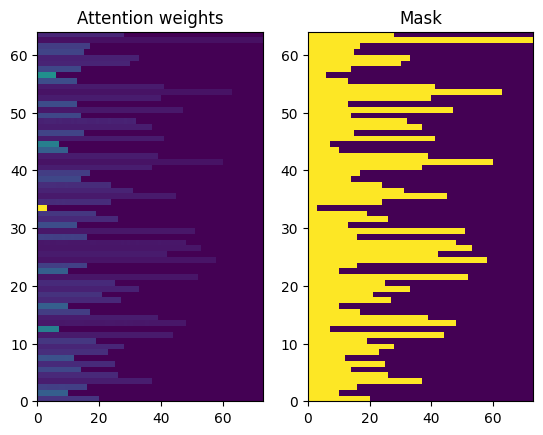

In [19]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [20]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [21]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
#   shape_checker = ShapeChecker()
#   shape_checker(x, 'batch t')
#   shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
#   shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
#   shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
#   shape_checker(x, 'batch t units')
#   shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
#   shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [22]:
decoder = Decoder(target_text_processor, UNITS)

In [23]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 73, 256)
input target tokens shape: (batch, t) (64, 67)
logits shape shape: (batch, target_vocabulary_size) (64, 67, 5000)


In [24]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [25]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [26]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [27]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'schulden zur strenger wirtschaft kompromi insbesondere intensiv beruflichen zerstoren dokuments',
       b'erscheint letzte urban generationen gestatten momentan wahlperiode teilnehmen chancengleichheit ware',
       b'verhalten entschlossen extremen da komplizierten binnenmarktes samtliche ruland beratung befurchtungen'],
      dtype=object)

In [28]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [29]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

(64, 73, 256)
Context tokens, shape: (batch, s, units) (64, 73)
Target tokens, shape: (batch, t) (64, 67)
logits, shape: (batch, t, target_vocabulary_size) (64, 67, 5000)


In [30]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [31]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [32]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [33]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [34]:
model.evaluate(val_ds, steps=20, return_dict=True)

(None, None, 256)
(None, None, 256)
20/20 [==============================] - 21s 693ms/step - loss: 8.5165 - masked_acc: 2.3119e-04 - masked_loss: 8.5165


{'loss': 8.516520500183105,
 'masked_acc': 0.00023118554963730276,
 'masked_loss': 8.516520500183105}

In [35]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
(None, None, 256)
(None, None, 256)
100/100 [==============================] - 177s 2s/step - loss: 5.7603 - masked_acc: 0.1420 - masked_loss: 5.7603 - val_loss: 4.9759 - val_masked_acc: 0.2185 - val_masked_loss: 4.9759
Epoch 2/100
100/100 [==============================] - 166s 2s/step - loss: 4.7385 - masked_acc: 0.2377 - masked_loss: 4.7385 - val_loss: 4.4990 - val_masked_acc: 0.2537 - val_masked_loss: 4.4990
Epoch 3/100
100/100 [==============================] - 168s 2s/step - loss: 4.4015 - masked_acc: 0.2642 - masked_loss: 4.4015 - val_loss: 4.2178 - val_masked_acc: 0.2830 - val_masked_loss: 4.2178
Epoch 4/100
100/100 [==============================] - 169s 2s/step - loss: 4.0511 - masked_acc: 0.2945 - masked_loss: 4.0515 - val_loss: 4.0620 - val_masked_acc: 0.2942 - val_masked_loss: 4.0620
Epoch 5/100
100/100 [==============================] - 167s 2s/step - loss: 3.8996 - masked_acc: 0.3100 - masked_loss: 3.8996 - val_loss: 3.8956 - val_masked_acc: 0.3133 - val_mask

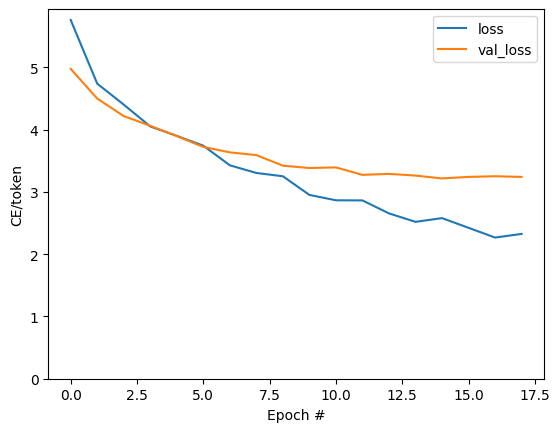

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

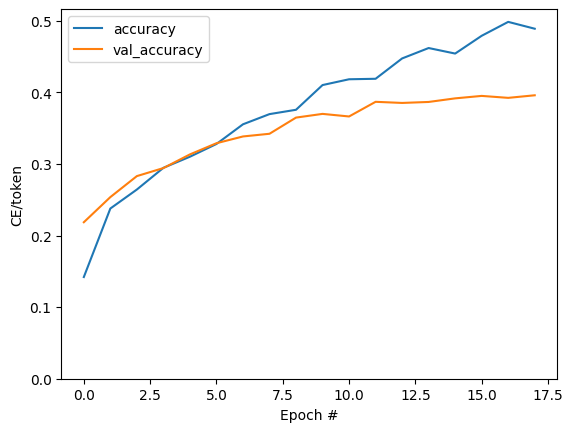

In [37]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [38]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [39]:
result = model.translate(['The commission has rejected the proposal']) 
result[0].numpy().decode()

(1, 8, 256)


'die kommission hat den vorschlag des rates [UNK] . '

In [40]:
from nltk.translate.bleu_score import sentence_bleu

for i in range(25001,25017): # evaluating 15 unseen sentences which were not a part of training data
    try:
        result = model.translate([europarl_lines_bp['English_Text'].values[i]]) 
        hypothesis = result[0].numpy().decode()
        print('Input Sentence', europarl_lines_bp['English_Text'].values[i])
        print('Predicted Sentence', hypothesis)
        print('Actual Sentence', europarl_lines_bp['German_Text'].values[i])
        hypothesis = str(hypothesis).split()
        reference = str(europarl_lines_bp['German_Text'].values[i]).split()
        #the maximum is bigram, so assign the weight into 2 half.
        BLEUscore = sentence_bleu([reference], hypothesis)
        print('BLEU Score:',BLEUscore, '\n')
    except:
        continue

(1, 35, 256)
Input Sentence We are therefore alert to any risk of weakening the principles that unite us in this area, and we have always denounced any violations through our common foreign and security policy.
Predicted Sentence wir sind also [UNK] , da die grundsatze in diesem bereich [UNK] , und wir haben immer wieder auf die achtung der gemeinsamen auen und sicherheitspolitik gesetzt . 
Actual Sentence Aus diesem Grund beobachten wir sehr aufmerksam alles, was eine Zuwiderhandlung gegen die Grundsätze darstellen könnte, die uns in diesem Bereich einen. Im Rahmen der Gemeinsamen Außen- und Sicherheitspolitik haben wir Verletzungen dieser Grundsätze stets angeprangert.
BLEU Score: 0.24822529802838886 

(1, 24, 256)


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence In such cases we seek to use the instruments available to us to exert pressure in a timely and effective way.
Predicted Sentence in derartigen fallen sind wir instrumente , die instrumente zu [UNK] , um [UNK] und effizienter zu gestalten . 
Actual Sentence In solchen Fällen versuchen wir, mit Hilfe des uns zu Gebote stehenden Instrumentariums Druck auszuüben, der sowohl zeitlich als auch in seinen Folgen wirkungsvoll sein kann.
BLEU Score: 0.3940631898226525 

(1, 31, 256)


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence We are aware that in many cases we have not achieved everything we might wish, but we firmly intend to continue in future with the same determination.
Predicted Sentence wir sind uns bewut , da wir in vielen fallen nicht erreicht haben , wir wollen , da wir in zukunft nicht erreichen wollen , aber wir mussen auch kunftig mit den gleichen entschlossenheit [UNK] . 
Actual Sentence Häufig haben wir - und dessen sind wir uns bewußt - das Gewünschte nicht erreicht. Wir sind jedoch fest entschlossen, auch künftig mit der gleichen Entschiedenheit vorzugehen.
BLEU Score: 0.7071067811865476 

(1, 40, 256)
Input Sentence Mr President, despite the gravity and the frequency of human rights violations that the Geneva Conventions and their protocols attempt to prevent, I do believe that the new millennium gives us some cause for hope.
Predicted Sentence herr prasident , trotz der [UNK] und [UNK] menschenrechtsverletzungen , die in new ubereinkommen und ihre protokolle uber die einhalt

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence It seems to us highly appropriate to speak in the European Parliament of regulations which have enriched humanity' s legal heritage and we should take every opportunity to recall and strengthen the validity of those instruments given the protection they offer and the rights they safeguard.
Predicted Sentence es erscheint uns wichtig , da wir in den europaischen parlament [UNK] , die [UNK] [UNK] [UNK] und [UNK] [UNK] und fordern wir alle organe und fordern und die [UNK] von denjenigen , die sie ermoglichen , und die rechte des burgers , die sie ermoglichen , und rechte des
Actual Sentence Wir halten es für völlig legitim, daß wir im Europäischen Parlament zu Normen Stellung nehmen, die den juristischen Besitzstand der Menschheit bereichert haben, und wir müssen jede Gelegenheit nutzen, um die Wirkung dieser Instrumente angesichts des durch sie gebotenen Schutzes und der durch sie garantierten Rechte in Erinnerung zu rufen und zu verstärken.
BLEU Score: 0.672489748161637 
